In [57]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

prev_curves = []
pre_curvature = []

In [70]:
def calibrate_camera(images):
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    for file_name in images:
        img = cv2.imread(file_name)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)

    # Calibrating the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
        
    return mtx, dist;

In [71]:
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img      

In [72]:
def process_image(img, mtx, dist, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = undistort_image(img, mtx, dist)
    img = np.copy(img)
    
    # Convert RGB to HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src * img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # this is good enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped_image = cv2.warpPerspective(img, M, dst_size, flags=cv2.INTER_LINEAR)
    return warped_image

def inverse_perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # this is good enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def get_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    #plt.title("Histogram", fontsize=30)
    #plt.show()
    return histogram

In [73]:
def find_lane_pixels(img, nwindows=9, margin=100, minpix = 50, draw_windows=True):
    global left_a, left_b, left_c, right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_histogram(img)    
    
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]//2) 
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
        
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 3) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    # averaging the last 10 polynomial coeficients
    if len(left_a) >= 10 :
        left_fit_[0] = np.mean(left_a[-10:])
        left_fit_[1] = np.mean(left_b[-10:])
        left_fit_[2] = np.mean(left_c[-10:])
        
        right_fit_[0] = np.mean(right_a[-10:])
        right_fit_[1] = np.mean(right_b[-10:])
        right_fit_[2] = np.mean(right_c[-10:])
    else:
        left_fit_[0] = left_fit[0]
        left_fit_[1] = left_fit[1]
        left_fit_[2] = left_fit[2]  
        
        right_fit_[0] = right_fit[0]
        right_fit_[1] = right_fit[1]
        right_fit_[2] = right_fit[2]        
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def get_curvature(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radio of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #calculating the values to meters
    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit, color):
    plot_lane = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, plot_lane]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, plot_lane])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), color)
    
    inverse_perspective = inverse_perspective_warp(color_img)
    inverse_perspective = cv2.addWeighted(img, 1, inverse_perspective, 0.8, 0)
    return inverse_perspective


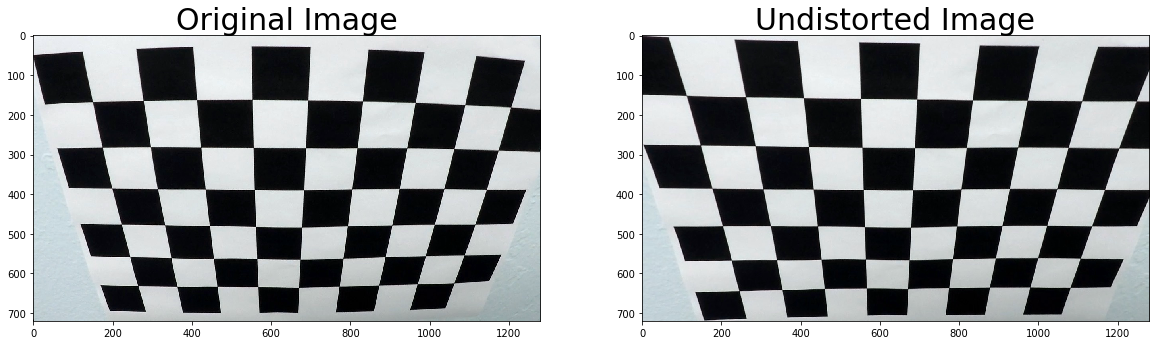

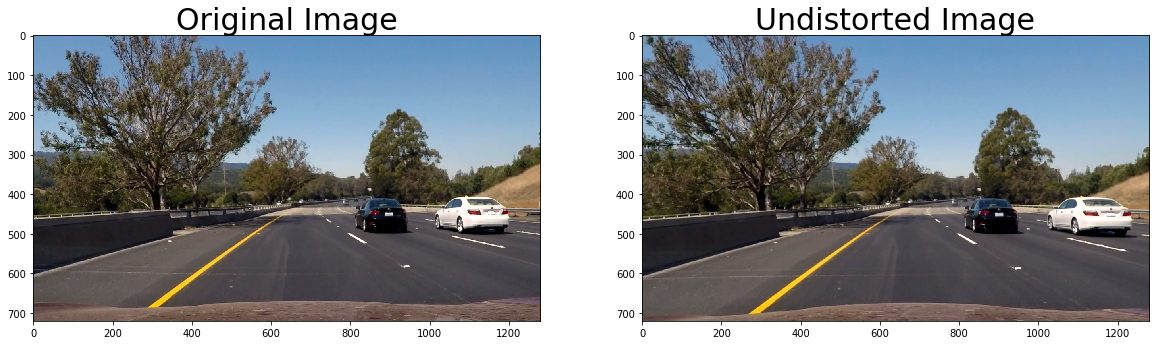

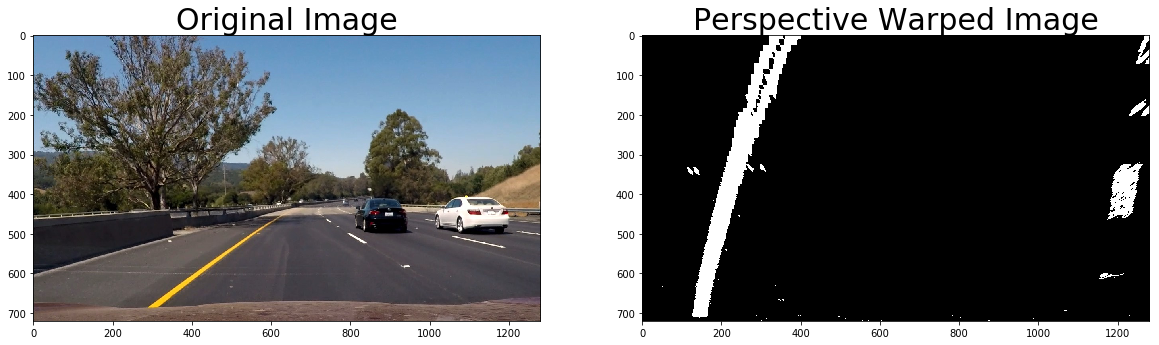

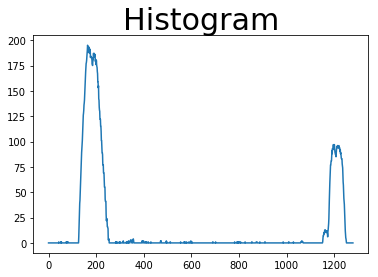

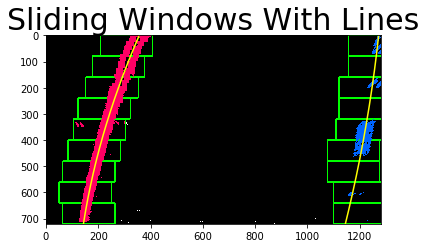

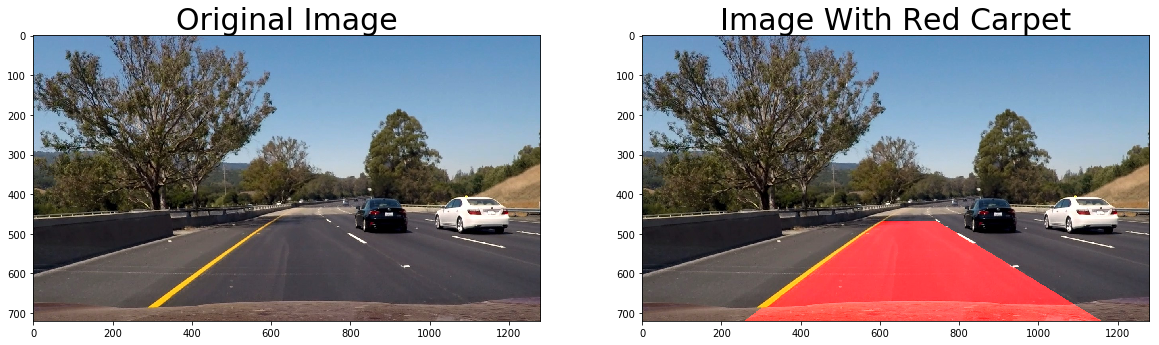

In [64]:
fname = 'test_images/test6.jpg'
images = glob.glob('camera_cal/*.jpg')
mtx, dist = calibrate_camera(images)

img = cv2.imread('camera_cal/calibration2.jpg')
undistort_img = undistort_image(img, mtx, dist)


# Visualize undistortion chessboard 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort_img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

# Visualize undistortion real image
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort_image(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = process_image(img, mtx, dist)
dst = perspective_warp(dst, dst_size=(1280,720))

# Visualize undistortion real image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Perspective Warped Image', fontsize=30)
plt.show()

left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]
out_img, curves, lanes, ploty = find_lane_pixels(dst)

# Plotting lines
plt.imshow(out_img, cmap='gray')
plt.title("Sliding Windows With Lines", fontsize=30)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

curverad=get_curvature(img, curves[0],curves[1])
color = (255,0,0)
image_with_lanes = draw_lanes(img, curves[0], curves[1], color)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_with_lanes, cmap='hsv')
ax2.set_title('Image With Red Carpet', fontsize=30)
plt.show()

In [77]:
def video_process(img):
    global running_avg
    global index
    global prev_curves
    global pre_curvature
    img_ = process_image(img, mtx, dist)
    img_ = perspective_warp(img_)
    out_img, curves, lanes, ploty = find_lane_pixels(img_, draw_windows=False)
    curverad = get_curvature(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])

    color = (255,0,0)
    img = draw_lanes(img, curves[0], curves[1], color)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=1
    cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (200, 50), font, fontSize, fontColor, 2)
    cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (200, 80), font, fontSize, fontColor, 2)
    return img

In [78]:
!pip install moviepy
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
right_curves, left_curves = [],[]

In [79]:
myclip = VideoFileClip('project_video.mp4')
output_video = 'project_video_output.mp4'
clip = myclip.fl_image(video_process)
clip.write_videofile(output_video, audio=False)

myclip.reader.close()
myclip.audio.reader.close_proc()

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:32,  8.27it/s]

  0%|          | 2/1261 [00:00<02:42,  7.77it/s]

  0%|          | 3/1261 [00:00<02:42,  7.76it/s]

  0%|          | 4/1261 [00:00<02:39,  7.90it/s]

  0%|          | 5/1261 [00:00<02:37,  7.97it/s]

  0%|          | 6/1261 [00:00<02:36,  8.00it/s]

  1%|          | 7/1261 [00:00<02:36,  8.03it/s]

  1%|          | 8/1261 [00:01<02:35,  8.08it/s]

  1%|          | 9/1261 [00:01<02:34,  8.10it/s]

  1%|          | 10/1261 [00:01<02:35,  8.07it/s]

  1%|          | 11/1261 [00:01<02:35,  8.01it/s]

  1%|          | 12/1261 [00:01<02:35,  8.03it/s]

  1%|          | 13/1261 [00:01<02:35,  8.04it/s]

  1%|          | 14/1261 [00:01<02:34,  8.05it/s]

  1%|          | 15/1261 [00:01<02:42,  7.68it/s]

  1%|▏         | 16/1261 [00:02<02:41,  7.72it/s]

  1%|▏         | 17/1261 [00:02<02:40,  7.75it/s]

  1%|▏         | 18/1261 [00:02<02:38,  7.86it/s]

  2%|▏         | 19/1261 [00:02<02:35,  7.98it/

 11%|█▏        | 143/1261 [00:26<03:39,  5.09it/s]

 11%|█▏        | 144/1261 [00:26<03:43,  5.00it/s]

 11%|█▏        | 145/1261 [00:26<03:49,  4.86it/s]

 12%|█▏        | 146/1261 [00:26<03:39,  5.08it/s]

 12%|█▏        | 147/1261 [00:26<03:48,  4.88it/s]

 12%|█▏        | 148/1261 [00:27<03:38,  5.09it/s]

 12%|█▏        | 149/1261 [00:27<03:46,  4.90it/s]

 12%|█▏        | 150/1261 [00:27<03:41,  5.01it/s]

 12%|█▏        | 151/1261 [00:27<03:45,  4.91it/s]

 12%|█▏        | 152/1261 [00:27<03:43,  4.97it/s]

 12%|█▏        | 153/1261 [00:28<03:43,  4.95it/s]

 12%|█▏        | 154/1261 [00:28<03:48,  4.85it/s]

 12%|█▏        | 155/1261 [00:28<03:38,  5.07it/s]

 12%|█▏        | 156/1261 [00:28<03:41,  4.98it/s]

 12%|█▏        | 157/1261 [00:29<03:47,  4.85it/s]

 13%|█▎        | 158/1261 [00:29<03:37,  5.07it/s]

 13%|█▎        | 159/1261 [00:29<03:39,  5.02it/s]

 13%|█▎        | 160/1261 [00:29<03:44,  4.90it/s]

 13%|█▎        | 161/1261 [00:29<03:35,  5.11it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [00:55<03:24,  4.77it/s]

 23%|██▎       | 285/1261 [00:55<03:21,  4.84it/s]

 23%|██▎       | 286/1261 [00:55<03:18,  4.91it/s]

 23%|██▎       | 287/1261 [00:55<03:16,  4.97it/s]

 23%|██▎       | 288/1261 [00:56<03:18,  4.89it/s]

 23%|██▎       | 289/1261 [00:56<03:10,  5.10it/s]

 23%|██▎       | 290/1261 [00:56<03:17,  4.92it/s]

 23%|██▎       | 291/1261 [00:56<03:09,  5.13it/s]

 23%|██▎       | 292/1261 [00:56<03:08,  5.15it/s]

 23%|██▎       | 293/1261 [00:56<03:03,  5.27it/s]

 23%|██▎       | 294/1261 [00:57<02:58,  5.43it/s]

 23%|██▎       | 295/1261 [00:57<02:59,  5.39it/s]

 23%|██▎       | 296/1261 [00:57<03:07,  5.14it/s]

 24%|██▎       | 297/1261 [00:57<03:02,  5.29it/s]

 24%|██▎       | 298/1261 [00:57<03:12,  5.01it/s]

 24%|██▎       | 299/1261 [00:58<03:04,  5.23it/s]

 24%|██▍       | 300/1261 [00:58<03:14,  4.94it/s]

 24%|██▍       | 301/1261 [00:58<03:06,  5.14it/s]

 24%|██▍       | 302/1261 [00:58<03:13,  4.95it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [01:24<02:55,  4.76it/s]

 34%|███▍      | 426/1261 [01:24<02:58,  4.67it/s]

 34%|███▍      | 427/1261 [01:24<02:50,  4.90it/s]

 34%|███▍      | 428/1261 [01:24<02:48,  4.93it/s]

 34%|███▍      | 429/1261 [01:24<02:54,  4.75it/s]

 34%|███▍      | 430/1261 [01:25<02:48,  4.94it/s]

 34%|███▍      | 431/1261 [01:25<02:52,  4.82it/s]

 34%|███▍      | 432/1261 [01:25<02:45,  5.02it/s]

 34%|███▍      | 433/1261 [01:25<02:53,  4.78it/s]

 34%|███▍      | 434/1261 [01:25<02:46,  4.96it/s]

 34%|███▍      | 435/1261 [01:26<02:51,  4.83it/s]

 35%|███▍      | 436/1261 [01:26<02:55,  4.71it/s]

 35%|███▍      | 437/1261 [01:26<02:47,  4.91it/s]

 35%|███▍      | 438/1261 [01:26<02:52,  4.77it/s]

 35%|███▍      | 439/1261 [01:26<02:44,  5.01it/s]

 35%|███▍      | 440/1261 [01:27<02:52,  4.75it/s]

 35%|███▍      | 441/1261 [01:27<02:44,  5.00it/s]

 35%|███▌      | 442/1261 [01:27<02:46,  4.91it/s]

 35%|███▌      | 443/1261 [01:27<02:51,  4.77it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [01:53<02:32,  4.56it/s]

 45%|████▍     | 567/1261 [01:53<02:27,  4.70it/s]

 45%|████▌     | 568/1261 [01:53<02:34,  4.49it/s]

 45%|████▌     | 569/1261 [01:53<02:30,  4.60it/s]

 45%|████▌     | 570/1261 [01:53<02:34,  4.46it/s]

 45%|████▌     | 571/1261 [01:54<02:28,  4.65it/s]

 45%|████▌     | 572/1261 [01:54<02:32,  4.52it/s]

 45%|████▌     | 573/1261 [01:54<02:27,  4.68it/s]

 46%|████▌     | 574/1261 [01:54<02:31,  4.55it/s]

 46%|████▌     | 575/1261 [01:54<02:27,  4.65it/s]

 46%|████▌     | 576/1261 [01:55<02:31,  4.52it/s]

 46%|████▌     | 577/1261 [01:55<02:25,  4.69it/s]

 46%|████▌     | 578/1261 [01:55<02:24,  4.73it/s]

 46%|████▌     | 579/1261 [01:55<02:23,  4.75it/s]

 46%|████▌     | 580/1261 [01:56<02:27,  4.62it/s]

 46%|████▌     | 581/1261 [01:56<02:23,  4.74it/s]

 46%|████▌     | 582/1261 [01:56<02:23,  4.73it/s]

 46%|████▌     | 583/1261 [01:56<02:32,  4.45it/s]

 46%|████▋     | 584/1261 [01:56<02:31,  4.46it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [02:23<01:50,  5.00it/s]

 56%|█████▌    | 708/1261 [02:23<01:46,  5.22it/s]

 56%|█████▌    | 709/1261 [02:23<01:50,  5.00it/s]

 56%|█████▋    | 710/1261 [02:23<01:44,  5.25it/s]

 56%|█████▋    | 711/1261 [02:23<01:49,  5.02it/s]

 56%|█████▋    | 712/1261 [02:24<01:44,  5.26it/s]

 57%|█████▋    | 713/1261 [02:24<01:48,  5.06it/s]

 57%|█████▋    | 714/1261 [02:24<01:43,  5.30it/s]

 57%|█████▋    | 715/1261 [02:24<01:46,  5.11it/s]

 57%|█████▋    | 716/1261 [02:24<01:42,  5.33it/s]

 57%|█████▋    | 717/1261 [02:25<01:49,  4.98it/s]

 57%|█████▋    | 718/1261 [02:25<01:44,  5.20it/s]

 57%|█████▋    | 719/1261 [02:25<01:48,  5.02it/s]

 57%|█████▋    | 720/1261 [02:25<01:44,  5.20it/s]

 57%|█████▋    | 721/1261 [02:25<01:47,  5.04it/s]

 57%|█████▋    | 722/1261 [02:25<01:41,  5.29it/s]

 57%|█████▋    | 723/1261 [02:26<01:45,  5.08it/s]

 57%|█████▋    | 724/1261 [02:26<01:41,  5.30it/s]

 57%|█████▋    | 725/1261 [02:26<01:46,  5.02it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [02:51<01:24,  4.88it/s]

 67%|██████▋   | 849/1261 [02:51<01:22,  4.97it/s]

 67%|██████▋   | 850/1261 [02:51<01:21,  5.07it/s]

 67%|██████▋   | 851/1261 [02:52<01:24,  4.87it/s]

 68%|██████▊   | 852/1261 [02:52<01:19,  5.12it/s]

 68%|██████▊   | 853/1261 [02:52<01:24,  4.81it/s]

 68%|██████▊   | 854/1261 [02:52<01:22,  4.96it/s]

 68%|██████▊   | 855/1261 [02:52<01:25,  4.77it/s]

 68%|██████▊   | 856/1261 [02:53<01:20,  5.01it/s]

 68%|██████▊   | 857/1261 [02:53<01:23,  4.84it/s]

 68%|██████▊   | 858/1261 [02:53<01:20,  5.00it/s]

 68%|██████▊   | 859/1261 [02:53<01:22,  4.86it/s]

 68%|██████▊   | 860/1261 [02:53<01:18,  5.08it/s]

 68%|██████▊   | 861/1261 [02:54<01:22,  4.88it/s]

 68%|██████▊   | 862/1261 [02:54<01:17,  5.12it/s]

 68%|██████▊   | 863/1261 [02:54<01:20,  4.94it/s]

 69%|██████▊   | 864/1261 [02:54<01:16,  5.17it/s]

 69%|██████▊   | 865/1261 [02:54<01:21,  4.88it/s]

 69%|██████▊   | 866/1261 [02:55<01:17,  5.13it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [03:19<00:53,  5.04it/s]

 79%|███████▊  | 990/1261 [03:20<00:56,  4.81it/s]

 79%|███████▊  | 991/1261 [03:20<00:53,  5.00it/s]

 79%|███████▊  | 992/1261 [03:20<00:54,  4.91it/s]

 79%|███████▊  | 993/1261 [03:20<00:54,  4.91it/s]

 79%|███████▉  | 994/1261 [03:20<00:54,  4.89it/s]

 79%|███████▉  | 995/1261 [03:21<00:54,  4.85it/s]

 79%|███████▉  | 996/1261 [03:21<00:55,  4.81it/s]

 79%|███████▉  | 997/1261 [03:21<00:58,  4.52it/s]

 79%|███████▉  | 998/1261 [03:21<00:56,  4.63it/s]

 79%|███████▉  | 999/1261 [03:22<00:55,  4.68it/s]

 79%|███████▉  | 1000/1261 [03:22<00:55,  4.72it/s]

 79%|███████▉  | 1001/1261 [03:22<00:54,  4.80it/s]

 79%|███████▉  | 1002/1261 [03:22<00:53,  4.80it/s]

 80%|███████▉  | 1003/1261 [03:22<00:56,  4.56it/s]

 80%|███████▉  | 1004/1261 [03:23<00:54,  4.72it/s]

 80%|███████▉  | 1005/1261 [03:23<00:54,  4.66it/s]

 80%|███████▉  | 1006/1261 [03:23<00:55,  4.61it/s]

 80%|███████▉  | 1007/1261 [03:23<00:56,  4.46it/s]

 80%

 89%|████████▉ | 1128/1261 [03:51<00:27,  4.81it/s]

 90%|████████▉ | 1129/1261 [03:51<00:26,  5.01it/s]

 90%|████████▉ | 1130/1261 [03:51<00:26,  4.89it/s]

 90%|████████▉ | 1131/1261 [03:51<00:25,  5.10it/s]

 90%|████████▉ | 1132/1261 [03:51<00:26,  4.90it/s]

 90%|████████▉ | 1133/1261 [03:52<00:25,  5.04it/s]

 90%|████████▉ | 1134/1261 [03:52<00:25,  4.91it/s]

 90%|█████████ | 1135/1261 [03:52<00:24,  5.12it/s]

 90%|█████████ | 1136/1261 [03:52<00:25,  4.99it/s]

 90%|█████████ | 1137/1261 [03:53<00:25,  4.85it/s]

 90%|█████████ | 1138/1261 [03:53<00:24,  5.06it/s]

 90%|█████████ | 1139/1261 [03:53<00:25,  4.85it/s]

 90%|█████████ | 1140/1261 [03:53<00:24,  4.98it/s]

 90%|█████████ | 1141/1261 [03:53<00:24,  4.85it/s]

 91%|█████████ | 1142/1261 [03:53<00:23,  5.03it/s]

 91%|█████████ | 1143/1261 [03:54<00:23,  4.96it/s]

 91%|█████████ | 1144/1261 [03:54<00:24,  4.80it/s]

 91%|█████████ | 1145/1261 [03:54<00:23,  4.98it/s]

 91%|█████████ | 1146/1261 [03:54<00:23,  4.81

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [45]:
myclip = VideoFileClip('challenge_video.mp4')
challenge_video_output = 'challenge_video_output.mp4'
clip = myclip.fl_image(video_process)
clip.write_videofile(challenge_video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))


[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:33<00:00,  5.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



In [46]:
myclip = VideoFileClip('harder_challenge_video.mp4')
output_video = 'harder_challenge_video_output.mp4'
clip = myclip.fl_image(video_process)
clip.write_videofile(output_video, audio=False)

myclip.reader.close()
myclip.audio.reader.close_proc()

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [04:49<00:00,  4.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

